<a href="https://colab.research.google.com/github/yukontaf/HeadRepo/blob/main/notebook44cc5cb8df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
from tensorflow import keras
tf.config.run_functions_eagerly(True)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adagrad, Adadelta, Adam, Adamax, Ftrl, Nadam, SGD, RMSprop 
from tensorflow.keras.layers import Bidirectional, Dense, LSTM, GRU, Conv1D, GlobalAveragePooling1D, Lambda, Flatten, Dropout, Embedding, Input, Normalization,\
Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.utils import plot_model
from tqdm import tqdm
matplotlib.style.use("seaborn-whitegrid")
pd.set_option("display.width", 5000)
pd.set_option("display.max_columns", 60)
plt.rcParams["figure.figsize"] = (15, 10)
import datetime
%config InlineBackend.figure_format = 'retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# AUTO = tf.data.experimental.AUTOTUNE

In [21]:
%%capture
!pip install ipdb
# !pip install gdown 
!pip install optuna
!apt install --assume-yes --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

In [22]:
import optuna
import pdb
from optuna.trial import TrialState

In [23]:
!gdown 12ceraaz41xJ503VhZlU-WnBB5pR8QWWf
!gdown 1mocZNvYWzWL9U-kygm9QU4ejuJoO0jyo

Downloading...
From: https://drive.google.com/uc?id=12ceraaz41xJ503VhZlU-WnBB5pR8QWWf
To: /content/train.feather
100% 12.2M/12.2M [00:00<00:00, 278MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mocZNvYWzWL9U-kygm9QU4ejuJoO0jyo
To: /content/test.feather
100% 45.8k/45.8k [00:00<00:00, 57.9MB/s]


In [24]:
norm = lambda x: (x-x.mean())/x.std()
df = pd.read_feather('/content/train.feather').drop('data_source', axis=1).dropna()
tm, ph = df['tm'], df['pH']
bins_tm, bins_ph = list(range(0,110,10)), np.arange(start=0,stop=10,step=0.5)
tm_cut, ph_cut = pd.cut(tm, bins_tm), pd.cut(ph, bins_ph)
df['tm_bin'], df['ph_bin'] = tm_cut, ph_cut
train = df.sample(frac = 0.8)
val = df.drop(train.index, axis=0)
test = pd.read_feather('/content/test.feather').drop('data_source', axis=1).dropna()

In [25]:
def split_seq(df):
    sentences = np.array([
    df[['protein_sequence']].to_numpy()[:, 0],
])
    splitted= []
    for i in sentences[0, :]:
        splitted.append(list(i))

    return np.array(splitted)

train_seq, val_seq, test_seq = split_seq(train), split_seq(val), split_seq(test)
le = LabelEncoder()
le.fit(df[['tm_bin']])

train_ph, val_ph, test_ph = train['pH'].to_numpy().reshape((len(train), 1)), val['pH'].to_numpy().reshape((len(val), 1)), test['pH'].to_numpy().reshape((len(test), 1))
train_tm, val_tm = train['tm'].to_numpy().reshape((len(train), 1)), val['tm'].to_numpy().reshape((len(val), 1))
train_labels, val_labels = le.fit_transform(train[['tm_bin']].to_numpy()), le.fit_transform(val[['tm_bin']].to_numpy())
le.fit(df[['ph_bin']])
train_ph_labels, val_ph_labels = le.fit_transform(train['ph_bin']), le.fit_transform(val['ph_bin'])
# train_labels, val_labels = keras.utils.to_categorical(train_labels), keras.utils.to_categorical(val_labels)

LabelEncoder()

LabelEncoder()

In [9]:
df['protein_sequence'].apply(lambda x: len(x)).quantile(0.90)

842.0

In [26]:
max_length = 1024
trunc_type='post'
embedding_dim = 64

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_seq)
sequences = tokenizer.texts_to_sequences(train_seq)
train_seq = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
vocab_size = len(tokenizer.word_index)
# train = Concatenate(axis=1)([tf.cast(train_seq.reshape(24883, 1024, 1), 'float32'), train_ph.reshape(24883, 1, 1), tf.cast(train_labels.reshape((24883, 1, 1)), 'float32')])


val_seq = tokenizer.texts_to_sequences(val_seq)
val_seq = pad_sequences(val_seq,maxlen=max_length)
# val = Concatenate(axis=1)([tf.cast(val_seq.reshape(len(val_seq), 1024, 1), 'float32'), val_ph.reshape(len(val_seq), 1, 1), tf.cast(val_labels.reshape((len(val_seq), 1, 1)), 'float32')])


tokenizer.fit_on_texts(test_seq)
test_seq = tokenizer.texts_to_sequences(test_seq)
test_seq = pad_sequences(test_seq, maxlen=max_length)
# test = np.append(test_seq, test_ph, 1)

In [28]:
# %pdb
import random, ipdb
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(11)]) - 1
    
    for d in range(11):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            # pdb.set_trace()
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(sequences, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(11)]
    # pdb.set_trace()
    pairs, y = create_pairs(sequences, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


train_pairs, train_y = create_pairs_on_set(train_seq, train_labels)
val_pairs, val_y = create_pairs_on_set(val_seq, val_labels)


In [29]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

from tensorflow.keras.losses import Loss

class ContrastiveLoss(Loss):
  def __init__(self, margin=1):
    super().__init__()
    self.margin = margin

  def __call__(self, y_true, y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(self.margin - y_pred, 0))
    return (1-y_true)*square_pred + y_true*margin_square

In [30]:
#@title
BATCH_SIZE = 1024
def preprocess(data):
    sequence = data[:-1]
    ph = tf.reshape(data[-2], (-1, ))
    tm =  data[-1]
    return sequence, ph, tm
def get_training_dataset(dataset):
    dataset = dataset.map(preprocess).shuffle(len(sequences)).batch(BATCH_SIZE).prefetch(64)
    return dataset
def get_validation_dataset(valid):
  valid = valid.map(preprocess).shuffle(len(sequences)).batch(BATCH_SIZE).prefetch(64)
  return valid
def concat(input):
    return tf.keras.layers.concatenate([input[0], input[1]], axis=1)

In [ ]:
#@title
# %pdb
class MyModel(tf.keras.Model):
  def __init__(self, lstm_layers, emb_dim, lstm_units, dropout_rate):
    super(MyModel, self).__init__()
    self.lstm_layers, self.emb_dim, self.lstm_units, self.dropout_rate = lstm_layers, emb_dim, lstm_units, dropout_rate
    self.input_ph = tf.keras.layers.Input((1,))
    self.input_seq = tf.keras.layers.Input((500, ))
    self.seq_layers =  [] 
    self.seq_layers.extend([tf.keras.layers.Embedding(21, emb_dim, name='embedding'),
                        tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
                        tf.keras.layers.Dropout(dropout_rate),  
                        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
                        tf.keras.layers.Dropout(dropout_rate),
                        *[tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(i, return_sequences=True, name=f'LSTM_{i}')) for j in range(lstm_layers-1) for i in lstm_units],
                        ])
    for i in range(len(self.seq_layers)):
      vars(self)[f'SEQ_LAYER_{i}'] = self.seq_layers[i]

    self.ph_layers = [
                      tf.keras.layers.Dense(512, name='dense1_ph', activation='relu'),
                      tf.keras.layers.Dropout(dropout_rate), 
                      tf.keras.layers.Dense(256, name='dense2_ph', activation='relu'),
                      tf.keras.layers.Dropout(dropout_rate), 
                      tf.keras.layers.Dense(128, name='dense3_ph', activation='relu'),
                      # tf.keras.layers.Dropout(dropout_rate),  
                      # tf.keras.layers.Dense(1, name='output_ph')
                      ]

    self.lambda_layer = tf.keras.layers.Lambda(function=concat, name='lambda_layer')
    self.flatten = tf.keras.layers.Flatten(name='flatten')
    self.dense_combined = tf.keras.layers.Dense(64, activation='relu', name='dense_combined')
    self.lambda_helper = tf.keras.layers.Lambda(lambda x: tf.reshape(x, (-1, 64, 1)))
    self.lstm_dense = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
    self.last_dense = tf.keras.layers.Dense(1, name='output')

  def call(self, inputs):
    seq, ph = inputs
    SEQ_LAYER_0 = vars(self)['SEQ_LAYER_0']
    x = SEQ_LAYER_0(seq)
    for i in range(1, self.lstm_layers):
        SEQ_LAYER_i = vars(self)[f'SEQ_LAYER_{i}']
        x = SEQ_LAYER_i(x)

    # for layer in self.seq_layers:
    #   seq = layer(seq)

    for layer in self.ph_layers:
      ph = layer(ph)

    x = self.lambda_layer([x, tf.tile(tf.reshape(ph, (-1, 128, 1)), (1, 1, x.shape[-1]))])
    x = self.flatten(x)
    x = self.dense_combined(x)
    x = self.lambda_helper(x)
    # x = self.lstm_dense(x)
    x = self.last_dense(x)
    return x
    

In [ ]:
#@title
TRAIN_STEPS = 15
PRUNING_INTERVAL_STEPS = 50
def objective(trial):    
  lstm_layers = trial.suggest_int('lstm_layers', 1, 7)
  emb_dim = trial.suggest_int('emb_dim', 256, 1024)
  lstm_units = []
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-7, 1)
  for i in range(lstm_layers):
    lstm_units.append(trial.suggest_int(f'lstm_units_l{i}', 16, 512))
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1)
  optimizer = trial.suggest_categorical('optimizer', [Adagrad, Adadelta, Adam, Adamax, Ftrl, Nadam, SGD, RMSprop])
  regressor = MyModel(lstm_layers, emb_dim, lstm_units, dropout_rate)
  loss_obj = tf.keras.metrics.MeanAbsoluteError(name='loss_obj')
  regressor.compile(loss=loss_obj, optimizer=optimizer(learning_rate=learning_rate))
  losses, n_train_iter, step = [], len(get_training_dataset(train)), 0
  for epoch in range(1):
    print(f'Epoch # {epoch} started')
    for batch in tqdm(get_training_dataset(train)):
      predictions = regressor([batch[0], batch[1]], training=True)
      loss = loss_obj(batch[2], predictions)
      losses.append(loss)
      if step > n_train_iter//2:
        intermediate_value = loss
        if intermediate_value < best_loss:
            raise optuna.TrialPruned()
      step += 1
      best_loss = min(losses)
    print(f'Training Loss {loss:.2f}, Best Loss: {best_loss:.2f}')
    for val_batch in tqdm(get_validation_dataset(val)):
      predictions = regressor([val_batch[0], val_batch[1]], training=False)
      val_loss = loss_obj(val_batch[2], predictions)
    print(f'Validation Loss {val_loss:.2f}')
  return val_loss

In [ ]:
#@title
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100)
# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

In [ ]:
#@title
# print("Best trial:")
# trial = study.best_trial

# trial

In [67]:
#@title
def model2(inputs):
    training = tf.estimator.ModeKeys.TRAIN
    seq, ph = inputs[0], inputs[1]
    concat = Concatenate(axis=1)([tf.cast(seq, dtype='int64'), tf.cast(ph, 'int64')])
    concat = Embedding(1026, 256)(concat)
    concat = GRU(64, activation='tanh', return_sequences=True)(concat)
    concat = GRU(8, activation='tanh')(concat)
    if training:
      concat = Dropout(0.2)(concat)
    concat = Dense(11, activation='softmax')(concat)
    model = Model(inputs=inputs, outputs=concat)
    return model

In [76]:
#@title
inputs_seq, inputs_ph = Input((1024,)), Input((1,))
model = model2([inputs_seq, inputs_ph])
adam, sgd, rms = Adam(1e-5), SGD(1e-4), RMSprop(1e-4)
loss_fn = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=adam, loss=loss_fn, metrics=['accuracy'])

In [86]:
def scheduler(epoch, lr):
  if epoch < 2:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
scheduler = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint(f'/content/model/weights.h5', verbose=1, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)
early_stopping = EarlyStopping(patience=3, min_delta=0.05, baseline=0.4, mode='max', monitor='val_accuracy', restore_best_weights=True, verbose=1)
tensorboard = tf.keras.callbacks.TensorBoard(logdir)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1024)]       0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 tf.cast_10 (TFOpLambda)        (None, 1024)         0           ['input_15[0][0]']               
                                                                                                  
 tf.cast_11 (TFOpLambda)        (None, 1)            0           ['input_16[0][0]']               
                                                                                            

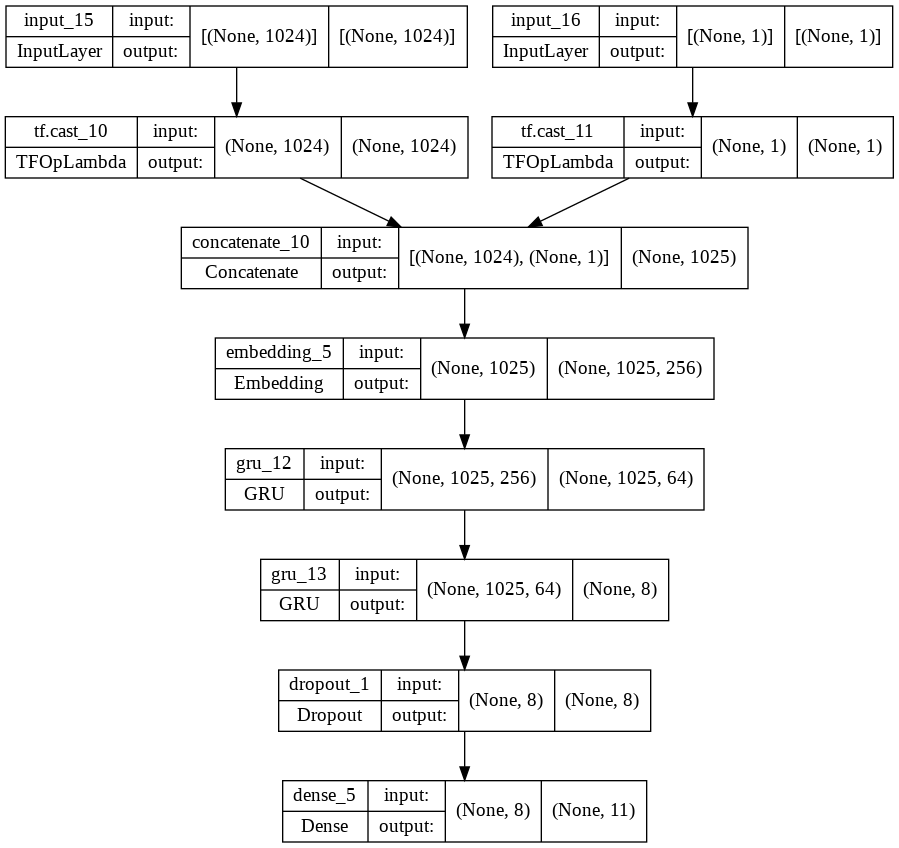

In [72]:
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
batch_size = 2
model.fit(x=[train_seq, train_ph_labels], y=train_labels, epochs=10, batch_size=batch_size, validation_data=([val_seq, val_ph_labels], (val_labels)), 
          verbose=1, validation_batch_size=batch_size, callbacks=[early_stopping, checkpoint, scheduler])

Epoch 1/10
 7158/12442 [================>.............] - ETA: 7:01 - loss: 1.8379 - accuracy: 0.3809

In [ ]:
#@title
seq, ph, tm = train[:,:-2], train[:,-2].reshape(-1,1), train[:,-1].reshape(-1,1)
scaler_ph, scaler_tm = StandardScaler(), StandardScaler()
train_ph, train_tm  = np.array(scaler_ph.fit_transform(ph)), np.array(scaler_tm.fit_transform(tm))
scaler_ph.fit(val[:,-2].reshape(-1,1)), scaler_tm.fit(val[:,-1].reshape(-1,1))
val_seq, val_ph, val_tm = val[:,:-2], scaler_ph.inverse_transform(val[:,-2].reshape(-1,1)), scaler_tm.inverse_transform(val[:,-1].reshape(-1,1))

In [ ]:
#@title
class G:
    TIME, SERIES = list(range(max_length)), sequences
    SPLIT_TIME = int(max_length*0.2)
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = train_seq.shape[0]
    LR = 2e-6

In [ ]:
#@title
def windowed_seq(ind, series=G.SERIES, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE,
                     shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    seq = tf.data.Dataset.from_tensor_slices(series[ind])
    seq = seq.window(window_size + 1, shift=1, drop_remainder=True)
    seq = seq.flat_map(lambda window: window.batch(window_size + 1))
    # seq = seq.shuffle(shuffle_buffer)
    seq = seq.map(lambda window: (window[:-1], window[-1]))
    seq = seq.batch(batch_size).prefetch(1)
    return seq

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Reshape, Conv1DTranspose, Conv1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau


In [ ]:
input_shape = (1024, 1)
batch_size = 16
kernel_size = 5
latent_dim = 2
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 32]

In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv1D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
shape = K.int_shape(x)

In [ ]:
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [ ]:
encoder = Model(inputs, latent, name='encoder')
# encoder.load_weights('/contents/encoder')
encoder.summary()
plot_model(encoder, to_file='encoder.png', show_shapes=True);

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 1024, 1)]         0         
                                                                 
 conv1d_50 (Conv1D)          (None, 512, 32)           192       
                                                                 
 conv1d_51 (Conv1D)          (None, 256, 32)           5152      
                                                                 
 flatten_11 (Flatten)        (None, 8192)              0         
                                                                 
 latent_vector (Dense)       (None, 2)                 16386     
                                                                 
Total params: 21,730
Trainable params: 21,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] )(latent_inputs)
x = Reshape((shape[1], shape[2]))(x)

In [ ]:
for filters in layer_filters[::-1]:
    x = Conv1DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

In [ ]:
outputs = Conv1DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_25 (Dense)            (None, 8192)              24576     
                                                                 
 reshape_6 (Reshape)         (None, 256, 32)           0         
                                                                 
 conv1d_transpose_30 (Conv1D  (None, 512, 32)          5152      
 Transpose)                                                      
                                                                 
 conv1d_transpose_31 (Conv1D  (None, 1024, 32)         5152      
 Transpose)                                                      
                                                                 
 decoder_output (Conv1DTrans  (None, 1024, 1)          161 

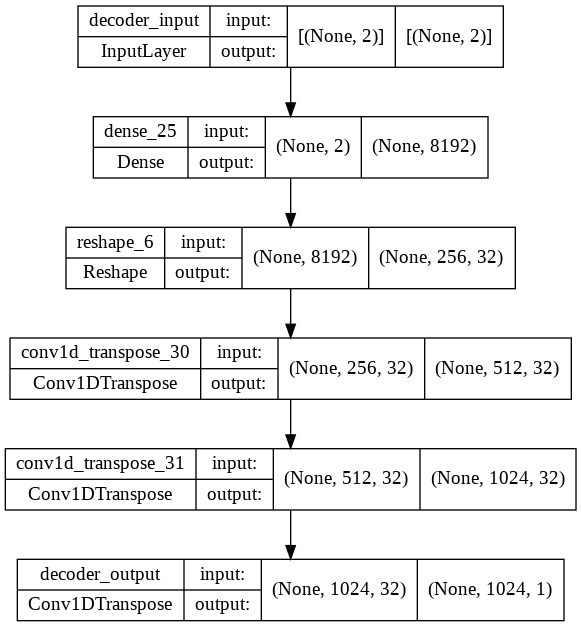

In [ ]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 1024, 1)]         0         
                                                                 
 encoder (Functional)        (None, 2)                 21730     
                                                                 
 decoder (Functional)        (None, 1024, 1)           35041     
                                                                 
Total params: 56,771
Trainable params: 56,771
Non-trainable params: 0
_________________________________________________________________


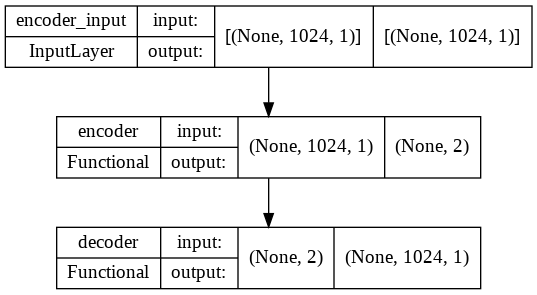

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

In [ ]:
autoencoder.compile(loss=MeanAbsoluteError(), optimizer=Adam(lr=0.001))

In [ ]:
autoencoder.fit(train_seq,
                train_seq,
                validation_data=(test_seq, test_seq),
                epochs=10,
              callbacks=[EarlyStopping(
              patience=5,
              min_delta=0.05,
              baseline=1.6,
              mode='min',
              monitor='val_loss',
              restore_best_weights=True,
              verbose=1)]
)

Epoch 1/10
778/778 [==============================] - 21s 27ms/step - loss: 2.7728 - val_loss: 1.5887
Epoch 2/10
778/778 [==============================] - 21s 27ms/step - loss: 2.7723 - val_loss: 1.5892
Epoch 3/10
778/778 [==============================] - 22s 28ms/step - loss: 2.7724 - val_loss: 1.5871
Epoch 4/10
778/778 [==============================] - 21s 26ms/step - loss: 2.7721 - val_loss: 1.5817
Epoch 5/10
778/778 [==============================] - 22s 28ms/step - loss: 2.7722 - val_loss: 1.5828
Epoch 5: early stopping


In [ ]:
predictions = autoencoder.predict(test_seq)

# Новый раздел

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
input_a = Input(shape=((1024, 1)), name="left_input")
vect_output_a = encoder(input_a)
input_b = Input(shape=(1024,1 ), name="right_input")
vect_output_b = encoder(input_b)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 1024, 1)]    0           []                               
                                                                                                  
 right_input (InputLayer)       [(None, 1024, 1)]    0           []                               
                                                                                                  
 encoder (Functional)           (None, 64)           7782        ['left_input[0][0]',             
                                                                  'right_input[0][0]']            
                                                                                                  
 output_layer (Lambda)          (None, 1)            0           ['encoder[2][0]',          

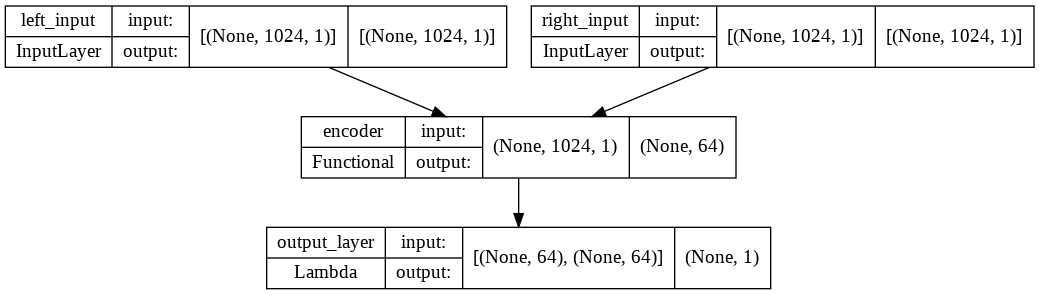

In [ ]:
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])
model = Model([input_a, input_b], output)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')


In [ ]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([train_pairs[:,0], train_pairs[:,1]], train_labels, epochs=100, batch_size=128, validation_data=([val_pairs[:,0], val_pairs[:,1]], val_labels), callbacks=[EarlyStopping(
              patience=5,
              min_delta=0.05,
              baseline=0.32,
              mode='min',
              monitor='val_loss',
              restore_best_weights=True,
              verbose=1),
              ])

Epoch 1/100
3/3 [==============================] - 0s 78ms/step - loss: 0.1880 - val_loss: 0.2497
Epoch 2/100
3/3 [==============================] - 0s 55ms/step - loss: 0.1803 - val_loss: 0.2467
Epoch 3/100
3/3 [==============================] - 0s 55ms/step - loss: 0.1793 - val_loss: 0.2453
Epoch 4/100
3/3 [==============================] - 0s 57ms/step - loss: 0.1740 - val_loss: 0.2469
Epoch 5/100
3/3 [==============================] - 0s 60ms/step - loss: 0.1731 - val_loss: 0.2526
Epoch 6/100
3/3 [==============================] - 0s 63ms/step - loss: 0.1757 - val_loss: 0.2458
Epoch 6: early stopping


In [ ]:
model.save('/contents/encoder')